---
# Práctica 1: Especificación y evaluación de argumentos causales.
Docente: Gustavo Landfried

Inferencia Bayesiana Causal 1

1er cuatrimestre 2025

UNSAM

Alumno: Tomás Pablo Korenblit

----

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os

---
## 1.1 Definir distribuciones condicionales
En esta sección, definimos varias distribuciones condicionales para los modelos que vamos a trabajar.

In [2]:
H = np.arange(3)  # Posibles valores para r, c, s (0,1,2)

def pr(r): 
    """Distribución marginal P(r) - igual para todos los modelos"""
    return 1/3

def pc(c): 
    """Distribución marginal P(c) - igual para todos los modelos"""
    return 1/3

def ps_rM0(s, r):
    """P(s|r) para Modelo Base (M0)"""
    return 0 if s == r else 1/2

def ps_rcM1(s, r, c):
    """P(s|r,c) para Modelo Monty Hall (M1)"""
    opciones_validas = [x for x in H if x != r and x != c]
    return 1/len(opciones_validas) if s in opciones_validas else 0

def prcs_M(r, c, s, m):
    """Distribución conjunta P(r,c,s|M)"""
    if m == 0:  # Modelo Base
        return pr(r) * pc(c) * ps_rM0(s, r)
    else:       # Modelo Monty Hall
        return pr(r) * pc(c) * ps_rcM1(s, r, c)

def ps_cM(s, c, m):
    """Calcula P(s|c, M) = P(s, c|M) / P(c|M)"""
    num = sum(prcs_M(r, c, s, m) for r in H)  # P(s, c|M)
    den = sum(prcs_M(r, c, s_, m) for r in H for s_ in H)  # P(c|M)
    return num / den if den > 0 else 0

def pr_csM(r, c, s, m):
    """Calcula P(r|c, s, M) = P(r, c, s|M) / P(c, s|M)"""
    num = prcs_M(r, c, s, m)
    den = sum(prcs_M(r_, c, s, m) for r_ in H)
    return num / den if den > 0 else 0

def pEpisodio_M(c, s, r, m):
    """Calcula P(c, s, r|M) usando descomposición en condicionales"""
    return pr_csM(r, c, s, m) * ps_cM(s, c, m) * pc(c)

---
## 1.2 Simular datos con modelo Monty Hall
Aquí simulamos datos usando el modelo Monty Hall.

In [3]:
def simular_datos(T=16, semilla=0):
    """Genera datos según el modelo Monty Hall (M1)"""
    np.random.seed(semilla)
    datos = []
    for _ in range(T):
        r = np.random.choice(3, p=[pr(h) for h in H])
        c = np.random.choice(3, p=[pc(h) for h in H])
        probs_h = [ps_rcM1(h, r, c) for h in H]
        s = np.random.choice(3, p=probs_h)
        datos.append((c, s, r))
    return datos

datos = simular_datos(T=16, semilla=0)

---
## 1.3 Predicción a priori de cada modelo
En esta sección se calcula la probabilidad de cada modelo antes de observar los datos.


In [4]:
def _secuencia_de_predicciones(datos, m):
    if m in [0, 1]:
        return [pEpisodio_M(c, s, r, m) for c, s, r in datos]
    if m == "a":
        return [pEpisodio_datosMa((c, s, r), datos) for c, s, r in datos]
    raise ValueError("Modelo no reconocido")

def pdatos_M(datos, m, log=False):
    """Calcula P(datos|M) para un modelo específico"""
    if log:
        return np.sum(np.log10(_secuencia_de_predicciones(datos, m)))
    else:
        return np.prod(_secuencia_de_predicciones(datos, m))

---
## 1.4 Predicción con contribución de todos los modelos
En esta sección sumamos la contribución de todos los modelos posibles.


In [5]:
def pM(m, alt=False):
    # Prior de los modelos
    return 1 / 3 if alt else 0.5

def pdatos(datos, alt=False):
    # sum_m P(datos,M=m)
    modelos = [0, 1, "a"] if alt else [0, 1]
    return sum([pdatos_M(datos, m) * pM(m, alt) for m in modelos])

---
## 1.5 Posterior de los modelos
Aquí calculamos la probabilidad posterior de cada modelo dado los datos observados.

In [6]:
def pM_datos(m, datos, alt=False):
    # P(M|datos)
    return (
        pdatos_M(datos, m)
        * pM(m, alt)
        / pdatos(datos, alt)
    )

## 1.6 Graficar evolución del posterior
En esta sección graficamos cómo cambia la probabilidad posterior a medida que se van observando más episodios.


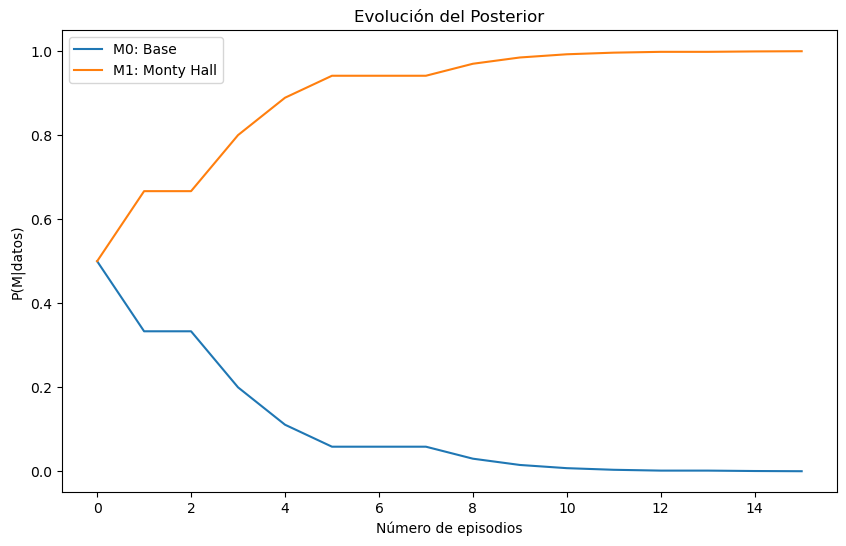

In [7]:
def lista_pM_datos(m, datos, alt=False):
    # [P(M | (c0,s0,r0) ), P(M | (c0,s0,r0),(c1,s1,r1) ), ... ]
    return [
        pM_datos(m, datos[:t], alt) for t in range(0, len(datos))
    ]
    
plt.figure(figsize=(10,6))
plt.plot(lista_pM_datos(m=0, datos=datos), label="M0: Base")
plt.plot(lista_pM_datos(m=1, datos=datos), label="M1: Monty Hall")
plt.xlabel('Número de episodios'), plt.ylabel('P(M|datos)')
plt.legend()
plt.title('Evolución del Posterior')
plt.show()

---
## 2.1 Posterior sobre probabilidad p (Modelo Alternativo)
En esta sección definimos las funciones para trabajar con el modelo alternativo y cargamos los datos reales desde el archivo CSV `nomontyhall.csv`.

In [8]:
def pa_p(a_t, p):
    return p if a_t else 1 - p

def pcst_p(c_t, s_t, r_t, p):
    output = 0
    for a_t in [0, 1]:
        if a_t == 0:
            output += pr(r_t) * pc(c_t) * pa_p(a_t, p) * ps_rM0(s_t, r_t)
        if a_t == 1:
            output += pr(r_t) * pc(c_t) * pa_p(a_t, p) * ps_rcM1(s_t, r_t, c_t)
    return output

def pp(p):
    if p < 0 or p > 1:
        return 0
    return 1

def pp_datos(p, datos):
    num = np.prod([pcst_p(c_t, s_t, r_t, p) for c_t, s_t, r_t in datos]) * pp(p)
    den = sum(
        np.prod([pcst_p(c_t, s_t, r_t, _p) for c_t, s_t, r_t in datos]) * pp(_p)
        for _p in np.linspace(0, 1, 11)
    )
    if num == 0:
        return 0
    return num / den

# Cargar NoMontyHall.csv
current_dir = os.path.dirname(os.path.abspath(''))
csv_path = os.path.join(current_dir, "data", "NoMontyHall.csv")
datos_reales = pd.read_csv(csv_path)[:20].to_numpy()

---
## 2.2 Predicción de episodio dado datos anteriores
Aquí calculamos la probabilidad de un episodio dado los datos anteriores.

In [9]:
def pEpisodio_datosMa(Episodio, datos):
    cT, sT, rT = Episodio
    posterior_prob = 0
    for p in np.linspace(0, 1, 11):
        posterior_prob += pcst_p(cT, sT, rT, p) * pp_datos(p, datos)
    return posterior_prob

---
## 2.3 Predicción completa del modelo alternativo
En esta sección calculamos la predicción completa para el modelo alternativo.

In [10]:
# Esto podría ser agregado más tarde si es necesario en el análisis.

## 2.4 Comparación de desempeño (log Bayes Factor)
Aquí comparamos los modelos mediante el logaritmo del Bayes factor.

In [11]:
def log_Bayes_factor(log_pdatos_Mi, log_pdatos_Mj):
    return log_pdatos_Mi - log_pdatos_Mj

log_pdatos_M0 = pdatos_M(datos_reales, m=0, log=True)
print(f"Logaritmo de P(datos|M0): {log_pdatos_M0:.5e}")

log_pdatos_M1 = pdatos_M(datos_reales, m=1, log=True)
print(f"Logaritmo de P(datos|M1): {log_pdatos_M1:.5e}")

log_pdatos_MA = pdatos_M(datos_reales, m="a", log=True)
print(f"Logaritmo de P(datos|MA): {log_pdatos_MA:.5e}")

Logaritmo de P(datos|M0): -2.51055e+01
Logaritmo de P(datos|M1): -inf
Logaritmo de P(datos|MA): -2.33407e+01


/var/folders/sm/x55wx2_x691c2_y5vd95x3cr0000gn/T/ipykernel_41614/484219784.py:11: RuntimeWarning: divide by zero encountered in log10
  return np.sum(np.log10(_secuencia_de_predicciones(datos, m)))


---
## 2.5 Predicción típica (media geométrica)
En esta sección, calculamos la media geométrica de las predicciones de los datos.

In [14]:
def geometric_mean(datos, m, log=False):
    if log:
        return np.mean(np.log10(_secuencia_de_predicciones(datos, m)))
    return np.prod(_secuencia_de_predicciones(datos, m)) ** (1 / len(datos))

print(
    "Logaritmo de la media geométrica de las predicciones de los datos para M0: ",
    geometric_mean(datos_reales, m=0, log=True),
)
print(
    "Logaritmo de la media geométrica de las predicciones de los datos para M1: ",
    geometric_mean(datos_reales, m=1, log=True),
)

print(
    "Logaritmo de la media geométrica de las predicciones de los datos para MA: ",
    geometric_mean(datos_reales, m="a", log=True),
)


Logaritmo de la media geométrica de las predicciones de los datos para M0:  -1.2552725051033062
Logaritmo de la media geométrica de las predicciones de los datos para M1:  -inf
Logaritmo de la media geométrica de las predicciones de los datos para MA:  -1.1670343358502975


/var/folders/sm/x55wx2_x691c2_y5vd95x3cr0000gn/T/ipykernel_41614/3830795717.py:3: RuntimeWarning: divide by zero encountered in log10
  return np.mean(np.log10(_secuencia_de_predicciones(datos, m)))


---
## 2.6 Graficar posteriores para primeros episodios
Aquí graficamos cómo evoluciona el posterior para los primeros episodios con los tres modelos.


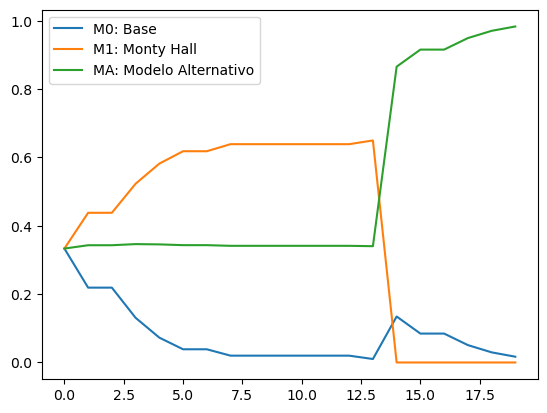

In [15]:
plt.plot(
    lista_pM_datos(m=0, datos=datos_reales, alt=True),
    label="M0: Base",
)
plt.plot(
    lista_pM_datos(m=1, datos=datos_reales, alt=True),
    label="M1: Monty Hall",
)
plt.plot(
    lista_pM_datos(m="a", datos=datos_reales, alt=True),
    label="MA: Modelo Alternativo",
)
plt.legend()
plt.show()